To DO:
* Make run equal to original simulate function

In [1]:
import jax
from jax import random
from jax import numpy as np
from jax import vmap, jit, grad
from jax.experimental import optimizers
import numpy as onp
import matplotlib.pyplot as plt
%matplotlib inline
import time

/home/joram/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load data
import pickle

with open('go_nogo_200.pickle', 'rb') as handle:
    d = pickle.load(handle)
print(d.keys())
y_go = d['y_go'] #/ d['y_go'].max()
y_go[150:] = 0 
y_nogo = d['y_nogo'] * 0 # let it be 0


dict_keys(['J0', 'J', 'w', 'I_go', 'I_nogo', 'y_go', 'y_nogo'])


/home/joram/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:144: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


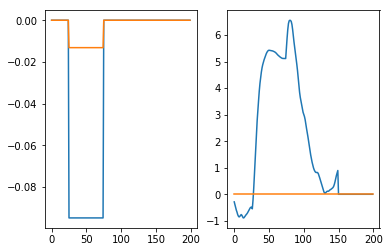

In [3]:
N = d['I_go'].shape[0]
Jinit = d['J0']
J = d['J']
w = d['w']
zN = np.zeros((25,N))
zNl = np.zeros((125,N))
z1 = np.zeros((1))
x_go = np.concatenate((zN, np.repeat(d['I_go'][None], axis=0, repeats=50), zNl))
x_nogo = np.concatenate((zN, np.repeat(d['I_nogo'][None], axis=0, repeats=50), zNl))
f, ax = plt.subplots(1, 2)
ax[0].plot(x_go.mean(1))
ax[0].plot(x_nogo.mean(1))
ax[1].plot(y_go)
ax[1].plot(y_nogo)

## Define network

In [4]:
def step_rnn(J, h, x):
    """ Perform one forward step """
    h = np.dot(J, h) + x
    return np.tanh(h)

def output(w, h):
    return np.dot(w, h)

batched_output = vmap(output, (None, 0))

def run(J, w, x_t):
    """ Simulate RNN for T time steps
        params : dict with keys J, w
        x_t : inputs, of shape (T, )
    """
    T, N = x_t.shape
    # Random initial condition
    key = random.PRNGKey(onp.random.randint(low=0, high=10**3))
    h = random.normal(key, shape=(N, ))
    h_t = []
    for x in x_t:
        h = step_rnn(J, h, x)
        h_t.append(h)
    h_t = np.array(h_t)
    o_t = batched_output(w, h_t)
    return h_t, o_t

batched_run = vmap(run, (None, None,0))

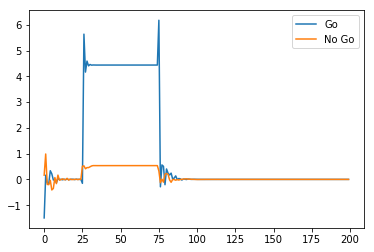

In [5]:
h_t, o_t = batched_run(d['J'], d['w'], x_go[None])
plt.plot(o_t[0], label = 'Go')
h_t, o_t = batched_run(d['J'], d['w'], x_nogo[None])
plt.plot(o_t[0], label = 'No Go')
plt.legend()

In [6]:
def compute_loss(J, w, inputs, targets):
    """ Inputs of size (nb_inputs, T, N) """
    _, outputs = batched_run(J, w, inputs)
    loss = np.mean((outputs - targets) ** 2)
    return loss

#loss_jit = jit(compute_loss)
#loss_jit(d['J'], d['w'], x_go[None], d['y_go'][None])

In [7]:
def update_weights(i, opt_state, opt_update, inputs, targets):
    J = optimizers.get_params(opt_state)
    def training_loss(J, w, x, y):
        return compute_loss(J,w,x,y)
    grads = grad(training_loss)(J,w,inputs,targets)
    return opt_update(i, grads, opt_state)

#update_weights_jit = jit(update_weights, static_argnums=(2,))

In [8]:
# Always show the same pattern
inputs = np.concatenate((x_go[None], x_nogo[None]))
targets = np.concatenate((y_go[None], y_nogo[None]))

In [ ]:
gamma = 0.99
decay_fun = optimizers.exponential_decay(step_size=1e-3, decay_steps=1, decay_rate=gamma)
opt_init, opt_update = optimizers.adam(decay_fun) 
init_J = d['J0']
opt_state = opt_init(init_J)
#update_weights_jit(0, opt_state, opt_update, inputs, targets)

In [ ]:
# don't jit, its super slow on cpu 
loss_hist = []
print_every = 10
for t in range(100):
    t0 = time.time()
    opt_state = update_weights(t, opt_state, opt_update, inputs, targets)
    t1 = time.time()
    if t % print_every == 0:
        J = optimizers.get_params(opt_state)
        l = compute_loss(J, w, inputs, targets)
        s = "Step {} in {:0.2f} sec, step size {:0.5f}, loss {:0.3f}"
        print(s.format(t, t1 - t0, decay_fun(t), l))
        loss_hist.append(l)
    

Step 0 in 3.47 sec, step size 0.00100, loss 4.153
Step 10 in 0.61 sec, step size 0.00090, loss 1.870
Step 20 in 0.68 sec, step size 0.00082, loss 1.404
Step 30 in 0.63 sec, step size 0.00074, loss 0.971
Step 40 in 0.93 sec, step size 0.00067, loss 1.694
Step 50 in 0.64 sec, step size 0.00061, loss 1.877
Step 60 in 0.62 sec, step size 0.00055, loss 1.379
Step 70 in 0.67 sec, step size 0.00049, loss 0.994


In [ ]:
plt.plot(loss_hist)

In [ ]:
h_t, o_t = batched_run(J, d['w'], x_go[None])
plt.plot(o_t[0], label = 'Go')
plt.plot(y_go, label = 'Go target')
h_t, o_t = batched_run(J, d['w'], x_nogo[None])
plt.plot(o_t[0], label = 'No Go')
plt.legend()